<a href="https://colab.research.google.com/github/MirelaBe/CNN/blob/main/Attributions_Grad_CAM%2B%2B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<p align="center">
  <img src="https://drive.google.com/uc?export=view&id=1K14-wQj7LHBUdqggMjcbRzwwUKGu426Q"/>
</p>

---

- 📘 <a href="https://deel-ai.github.io/xplique"> Documentation </a>
- <img src="https://github.githubassets.com/images/icons/emoji/octocat.png" width=20> <a href="https://github.com/deel-ai/xplique"> Github </a>
- 🦊 <a href="https://github.com/deel-ai/xplique/blob/master/TUTORIALS.md"> More Xplique tutorials </a>

---
# 👋 Welcome to the **Grad-CAM++ attribution** tutorial

In this tutorial, we will take a pre-trained model, compute explanations from different images and explainers and we will try to cover the main utilities of this attribution method.

💡 The Grad-CAM++ attribution method is derived from the paper: [Grad-CAM++: Improved Visual Explanations for Deep Convolutional Networks](https://arxiv.org/abs/1710.11063).
We integrated it into the Xplique framework and propose here to have an overview of the possibilities you have to play with the Grad-CAM++ method to explain the outputs of your model.

<p align="center">
  <img src="https://drive.google.com/uc?export=view&id=1COI9FzTXCMlbRq-RHNy0C70qJcIPvMCk" />
</p>

## Table of content:
0. [Set-up](#setup)

1. [Attributes Overview](#overview)

    a. [Method Overview](#method)
    
2. [Advanced settings](#advanced)

**Note:** The Xplique library was developed to be faster when running on GPU.

## <a id="sec">0. Set-up</a>

We start by importing Xplique and some other necessary libraries.

In [ ]:
!pip install -U -q xplique

     |████████████████████████████████| 87 kB 2.5 MB/s 


In [ ]:
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
from math import ceil

import xplique
from xplique.attributions import GradCAMPP
from xplique.plots import plot_attributions

Now we will load an image and a well-known model [Inception V3](https://keras.io/api/applications/inceptionv3/).

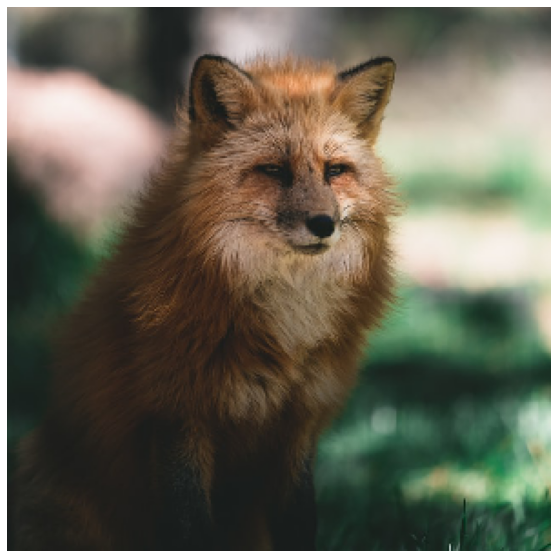

In [ ]:
# load, prepare and show the sample
!wget -q 'https://unsplash.com/photos/XOxsVJmCyxk/download?force=true&w=640' -O 'fox.jpg'

x = np.expand_dims(tf.keras.preprocessing.image.load_img("fox.jpg", target_size=(299, 299)), 0)
x = np.array(x, dtype=np.float32) / 255.0

y = np.expand_dims(tf.keras.utils.to_categorical(277, 1000), 0)

plt.rcParams["figure.figsize"] = [25,10]
plt.imshow(x[0])
plt.axis('off')
plt.show()

In [ ]:
# load the model
model = tf.keras.applications.InceptionV3()

96124928/96112376 [==============================] - 1s 0us/step


**Just to try we will use the most basic way to use GradCAM++**

In [ ]:
model.layers[-1].activation = tf.keras.activations.linear
first_explainer = GradCAMPP(model, output_layer=-1, conv_layer=None)

In [ ]:
first_explanation = first_explainer.explain(x, y)

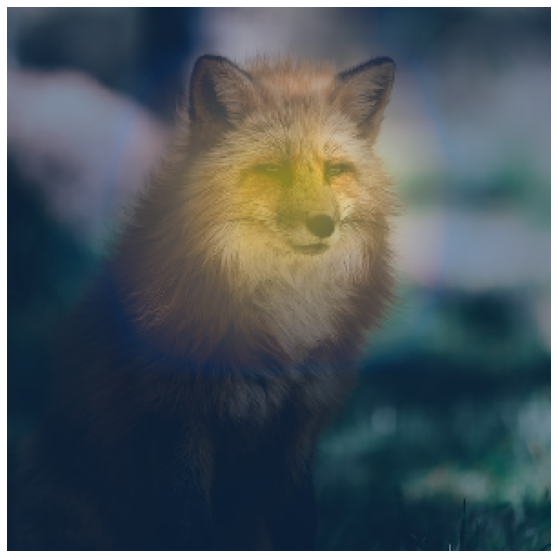

In [ ]:
plot_attributions(first_explanation, x, img_size=7., cmap='cividis', cols=1)

The Grad-CAM++ method needs a little bit of knowledge to use it to its full potential by choosing the adaptative parameters (see the [paper](https://arxiv.org/abs/1710.11063)). The parameters are explained in the following chapter.


## <a id="overview">1. Attributes Overview </a>

As most methods of the Xplique library, an explanation method have a few number of attributes (and their default values) useful to increase your explanation quality.

```python
explainer = GradCAMPP(model,
                    output_layer: int = -1,
                    batch_size: int = 32,
                    conv_layer = None)
```

The `output_layer` parameter is the index of the output layer corresponding to the label layer. The last layer layers can be activated (linear, softmax ...). The value of `output_layer` has no impact on the simulation time.

The `batch_size` define the number of inputs to treat simultaneously.

The `conv_layer` parameter is the layers on which the Grad-CAM++ algorithm is applied (see following chaper). The value of `conv_layer` has no impact on the simulation time.

The choice of the `conv_layer` and the `output_layer` have a great deal towards our explainer performance. The `conv_layer` layer has to be before the `output_layer` layer in the neural network system.

The method is more precidely detailed in the following paragraph.

For a detailed review of all this attributes, please refer to the source code documentation.

### <a id="#method">a. Method overview</a>

The approach of Grad-CAM++ is a generalization of Grad-CAM and CAM, techniques for identifying discriminative regions, for a wide variety of CNN-based architectures.

Grad-CAM++, like Grad-CAM, uses the gradient information flowing into a convolutional layer $y$ of the CNN to assign importance values to each neuron for a particular decision of interest.

For a class $c$, a feature $k$, a targeted layer $A$ and some weights $w^c_k$, the class-discriminative localization map Grad-CAM++ $L^c_{Grad-CAM++}$ is formulated as:

$$L^c_{Grad-CAM++} = ReLU\Big(\underset{k}{\sum}{w^c_k A^k}\Big)$$

A ReLU is applied to the linear combination of forward activation maps because we are only interested in the features that have a positive influence on the class of interest, i.e. pixels whose intensity should be increased in order to increase $y^c$.

The weights $w^c_k$ represent a partial linearization of the deep network downstream from the layer $A$, and captures the ‘importance’ of feature map $k$ for a target class $c$.

The difference between Grad-CAM and Grad-CAM++ is the computation of the weights, which can be computed as a global-average-pool of a partial linearization of gradients of the score of the layer $y$ and for the class $c$, and the feature map of the layer $A$ $\Big(\frac{\delta{y^c}}{\delta{A^k}}\Big)$:

$$w^c_k = \underset{i}{\sum}\underset{j}{\sum}\alpha_{ij}^{kc}\cdot ReLU\Big(\frac{\delta{y^c}}{\delta{A^k_{ij}}}\Big)$$

$i, j$ being the indexes of the width and height dimensions of the layer $A^k$.

With $S_c$ the penultimate layer scores for the class $c$, the gradient coefficients of $w^c_k$ are computed as:

$$\alpha_{ij}^{kc} = \frac{\Big(\frac{\delta{S^c}}{\delta{A^k_{ij}}}\Big)^2}{2 \Big(\frac{\delta{S^c}}{\delta{A^k_{ij}}}\Big)^2 + \underset{a}{\sum}\underset{b}{\sum}A_{ab}^k\Big(\frac{\delta{S^c}}{\delta{A^k_{ij}}}\Big)^3}$$

## <a id="advanced">2. Advanced Settings</a>

Before seeing the impact of the advanced parameters on an explanation, we will see the effect of a bad paremeter settings:

In [ ]:
model.layers[-1].activation = tf.keras.activations.softmax
output_layer = -1
conv_layer = 35
bad_settings_explainer = GradCAMPP(model, output_layer=output_layer, conv_layer=conv_layer)

/usr/local/lib/python3.7/dist-packages/xplique/attributions/base.py:119: UserWarning: Output is after softmax, it is recommended to use the layer before.
  warnings.warn("Output is after softmax, it is recommended to "


In [ ]:
bad_settings_explanation = bad_settings_explainer.explain(x, y)

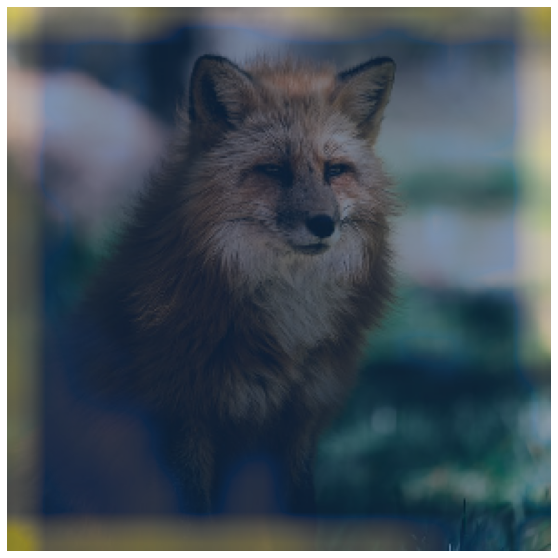

In [ ]:
plot_attributions(bad_settings_explanation, x, img_size=7., cmap='cividis', cols=1)

Well as you might notice the explainer as it is performs quite poorly: the explanation is not quite convincing.

Several reasons to it:

* The activation of the last layer is softmax. A linear activation is better.

* The layer where the Grad-CAM++ algorithm is $ceil(len(model.layers)/2)$. Grad-CAM++ applied to all layers is better.

Once we have seen a little bit of theory towards the Grad-CAM++ method, we have a more pratical approach to get a better explanation than our approach. 

We choose a linear activation for the last layer of the NN.

In [ ]:
model.layers[-1].activation = tf.keras.activations.linear

We are now ready to have another advanced explainer.

In [ ]:
advanced_explainer = GradCAMPP(
    model,
    output_layer=output_layer,
    conv_layer=conv_layer
)

And we are ready to ask him some explanations concerning the fox:

In [ ]:
advanced_explanation = advanced_explainer.explain(x, y)

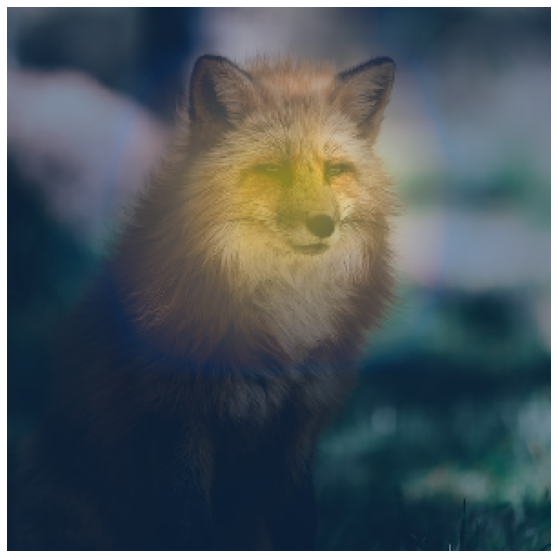

In [ ]:
plot_attributions(advanced_explanation, x, img_size=7., cmap='cividis', cols=1)

The explanation is much better. To fine tune it, we can choose a value of `conv_layer` which corresponds to the whole neural networks and results to better explanation.



In [ ]:
conv_layer = None

In [ ]:
real_advanced_explainer = GradCAMPP(
    model,
    output_layer=output_layer,
    conv_layer=conv_layer
)

In [ ]:
real_advanced_explanation = real_advanced_explainer.explain(x, y)

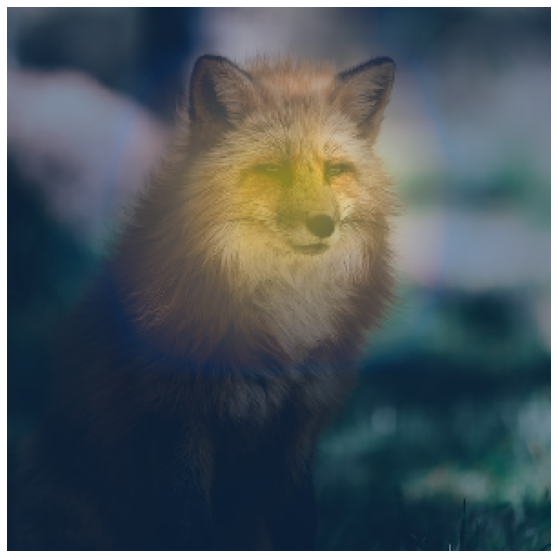

In [ ]:
plot_attributions(real_advanced_explanation, x, img_size=7., cmap='cividis', cols=1)

As you might notice, setting correctly the parameters lead to an explanation close to the cover.

Finally, you probably noticed the `batch_size` argument in the Grad-CAM++ constructor. It is possible to treat inputs per batch.

Have a look to a larger number of data:

In [ ]:
!wget -nv 'https://unsplash.com/photos/X2PwqTUpXH8/download?force=true&w=640' -O 'fox1.jpg'
!wget -nv 'https://unsplash.com/photos/tIfrzHxhPYQ/download?force=true&w=640' -O 'fox2.jpg'
!wget -nv 'https://unsplash.com/photos/LVnJlyfa7Zk/download?force=true&w=640' -O 'sea_turtle.jpg'
!wget -nv 'https://unsplash.com/photos/sSEEbAzB6fU/download?force=true&w=640' -O 'lynx.jpg'
!wget -nv 'https://unsplash.com/photos/41dAczoRYJY/download?force=true&w=640' -O 'cat.jpg'
!wget -nv 'https://unsplash.com/photos/axqTLZ12Jss/download?force=true&w=640' -O 'otter.jpg'

2021-08-25 13:05:37 URL:https://images.unsplash.com/photo-1615602127413-459bdb48cf45?ixlib=rb-1.2.1&q=80&fm=jpg&crop=entropy&cs=tinysrgb&dl=phil-plante-X2PwqTUpXH8-unsplash.jpg&w=640 [68671/68671] -> "fox1.jpg" [1]
2021-08-25 13:05:38 URL:https://images.unsplash.com/photo-1516934024742-b461fba47600?ixlib=rb-1.2.1&q=80&fm=jpg&crop=entropy&cs=tinysrgb&dl=sunguk-kim-tIfrzHxhPYQ-unsplash.jpg&w=640 [87759/87759] -> "fox2.jpg" [1]
2021-08-25 13:05:39 URL:https://images.unsplash.com/photo-1496196614460-48988a57fccf?ixlib=rb-1.2.1&q=80&fm=jpg&crop=entropy&cs=tinysrgb&dl=randall-ruiz-LVnJlyfa7Zk-unsplash.jpg&w=640 [89904/89904] -> "sea_turtle.jpg" [1]
2021-08-25 13:05:40 URL:https://images.unsplash.com/photo-1552833172-fd5ac167c18c?ixlib=rb-1.2.1&q=80&fm=jpg&crop=entropy&cs=tinysrgb&dl=zdenek-machacek-sSEEbAzB6fU-unsplash.jpg&w=640 [97875/97875] -> "lynx.jpg" [1]
2021-08-25 13:05:41 URL:https://images.unsplash.com/photo-1616588945355-bb09c77baf29?ixlib=rb-1.2.1&q=80&fm=jpg&crop=entropy&cs=tinys

In [ ]:
img_list = [
    ('fox1.jpg', 277),
    ('fox2.jpg', 277),
    ('sea_turtle.jpg', 33),
    ('lynx.jpg', 287),
    ('cat.jpg', 281),
    ('otter.jpg', 360)
]

In [ ]:
imgs = []
labels = []

for img_name, label in img_list:
    img = tf.keras.preprocessing.image.load_img(img_name, target_size=(299, 299))
    label = tf.keras.utils.to_categorical(label, 1000)

    imgs.append(img)
    labels.append(label)

imgs = np.stack(imgs, axis=0)
imgs = np.array(imgs, dtype=np.float32) / 255.0

labels = np.stack(labels, axis=0)

In [ ]:
batch_explainer = GradCAMPP(
    model,
    batch_size=2,
    output_layer=output_layer,
    conv_layer=conv_layer
)

In [ ]:
batch_explanations = batch_explainer.explain(imgs, labels)

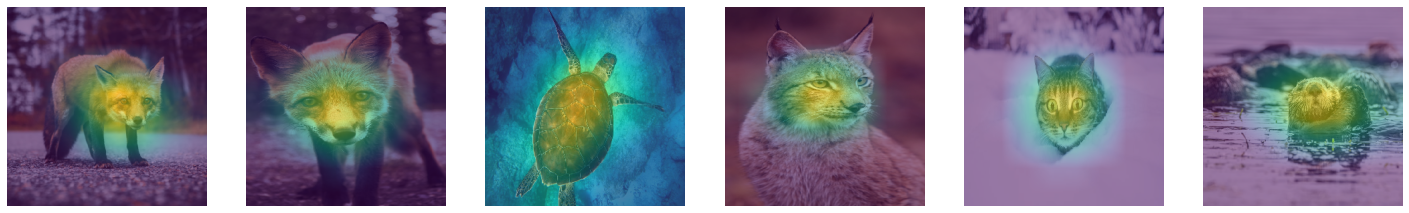

In [ ]:
plot_attributions(batch_explanations, imgs, img_size=3.5, cmap='viridis', cols=6)

**N.B**: If you have a large dataset it might even be necessary to the set the batch size parameter from a memory perspective.